# DEND Capstone project

##Introduction

###Iowa Liquor Sales from Kaggle

https://www.kaggle.com/residentmario/iowa-liquor-sales


**Disclaimer**
>I will use a slightly modifiyed version of the original file. The reason behind this is when I started this project I used `pandas` but figured out that it was not optimal enough (memory usage issue) and switch to spark instead.
>
>The original file there is a column named **Store Location** (containing GPS coordinates + the full address => `1013 MAIN\nKEOKUK 52632\n(40.39978, -91.387531)`) where there is `\n` char inside. While pandas is able to reconize a string containing `\n` as a whole value, spark is more strict and stick with the CSV standard. The dataframe with spark was totally messed up.
>
>Since I don't have control over the data production, I simply load the csv into pandas on my local machine, drop this column and write a new csv that is available on S3.
>
>If you want to play this Notebook you gonna need to do the same or download the modofiyed version [here](https://drive.google.com/open?id=1xg3LNf4soTNh848ZV8aKjk1FkTt8M5ye).

To be able to ETL this file we need to get information about. This file is quite challenging since its ~3.5GB and +12 Millions rows to wrangle. A little bit too much for a single computer if we want acceptable time efficiency but doesn't need a big cluster either. That's why I decided to work on this project with Spark for the calculated distribution capabilities but on this powerful Notebook from Google and not have to setup something on a cloud provider like Azure, AWS or GCP.

## Explore the Dataset


I will first get informations about the data type of each columns and explore the dataset. We can work on the first 20 rows to get insight then refine the dataset with the observation made.

### Installation of the needed package

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-eu.apache.org/dist/spark/spark-2.4.3/spark-2.4.3-bin-hadoop2.7.tgz
!tar xf spark-2.4.3-bin-hadoop2.7.tgz
!pip install -q findspark

### Setup environnement variable

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.3-bin-hadoop2.7"

# This line install 2 package to pyspark when it's first load
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk:1.11.612,org.apache.hadoop:hadoop-aws:2.6.5 pyspark-shell'

### Setup Spark

In [0]:
# Using findspark to locate my spark installation automaticaly
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession

# Build a SparkSession using all the core (GPU here) available on this VM.
# You can change for your own Spark instance on the cloud if wanted.
spark = SparkSession.builder.appName("DEND_Capstone").master("local[*]").getOrCreate()

# Enable Arrow-based columnar data transfers
# https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
# spark.conf.set("spark.sql.execution.arrow.enabled", "true")

### Upload AWS IAM credential

In [0]:
# This snippet is from Google to let upload a file into the session
# Few time the JS fail to load  ¯\_(ツ)_/¯  . It's a known issue - just launch the cell a second time will make it work

# Create an IAM AWS User with the permision AmazonS3FullAccess
# Get the csv file as credential.csv ready to upload here
from google.colab import files
files.upload()

In [0]:
import pandas as pd

aws = pd.read_csv('credentials.csv')

spark.sparkContext._jsc.hadoopConfiguration().set('fs.s3a.access.key', aws.iloc[0][2])
spark.sparkContext._jsc.hadoopConfiguration().set('fs.s3a.secret.key', aws.iloc[0][3])

### Load the modifiyed csv

You gonna need to change the path with your S3 URL if you want to follow the process

In [0]:
# Read the modified csv file from S3 bucket
path = "s3a://capstone-dend/data.csv"
ddf = spark.read.csv(path, inferSchema=True, header=True)

ddf.show()

In [0]:
# A lookup to the data types
ddf.dtypes

## Sample Analysis

From this **sample** I can start to come to some conclusion :

1. I can identify the column's name easily and start guessing the data type of each columns. That will speed up the reading of the full dataset later. I will also reformat the columns names to lowercase to be more clear and consistent.

2. The column `Invoice/Item Number` seems to be a unique identifier that I can use for each rows. Change the name of the column to be `id` and use it later to identify each payment for the fact table.
3. `Date` is obviously a date format that I have to be converted from `string` to `date`.
4. `ZipCode` is automatically typed as `string` because despite most of the data look like a numeric value, as attended, we have row 9 : `712-2`. I quick search on my favourite search engine [Qwant](www.qwant.com) shows me that it's an Area Code and not a Zip Code. I will convert this colum as a numeric type and then consider `NaN` a non numeric value for the Area Code.
5. Since there is some errors to handle on the **Store Location** column that I drop from the original dataset, I will use the [Geocoding Google API](https://developers.google.com/maps/documentation/geocoding/intro) to create a `Lat`, `Lon` columns with the right values later in the ETL process.
6. For future calculation it's going to be easier if the currency value is treated as numeric. I need to get rid of the dollard sign and convert the value as cents to handle integer instead of float (Bank and fintech use this optimization to handle billions of transaction with less memory usage).
7. We have the bottle volume as **ml** (milliliter) and we have total `Volume Sold` in both **liters** and **gallons**. I prefer to use the [SI](https://en.wikipedia.org/wiki/International_System_of_Units) units for more convinence. So I will get rid of the extra column in **gallon**'s unit and convert the **liter** unit to **ml** for the same reason as the currency column's values.

*Let try to do this 7 steps on this sample data. That will be useful for the final ETL in a wrangling step.*


## Date Wrangling

### Step 1 - Normalize the column's name

In [0]:
# First let's format headers name more clearly
ddf = ddf.toDF(*[c.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for c in ddf.columns])
ddf.columns

### Step 2 - Renaming column to `id`

In [0]:
ddf1 = ddf.withColumnRenamed('invoice/item_number','id')

### Step 3 - Casting `date` column to a date type

In [0]:
from pyspark.sql.functions import to_date, col

ddf2 = ddf1.withColumn("date", to_date(col("date"), "MM/dd/yyyy"))
ddf2.show(n=10)
ddf2.dtypes

### Step 4 - Casting `zip_code` to `int` 

In [0]:
from pyspark.sql.types import IntegerType

ddf3 = ddf2.withColumn("zip_code", ddf2["zip_code"].cast(IntegerType()))
ddf3.show(n=10)
ddf3.dtypes

# #  df.filter(df["age"]>24).show()lambda ((l,v), i): i == myIndex
# ddf3.filter(ddf3['id'] == 'S03816000008').show()

### Step 5 - Doing later

### Step 6 - Working on currency columns

#### Step 6.1.a - Removing the dollard sign to `State Bottle Cost` 

In [0]:
from pyspark.sql.functions import expr

ddf4 = ddf3.withColumn('state_bottle_cost', expr("substring(state_bottle_cost, 2, length(state_bottle_cost))"))

ddf4.show()

#### Step 6.1.b - Converting to `int` as cent

In [0]:
from pyspark.sql.types import DoubleType

ddf5 = ddf4.withColumn('state_bottle_cost', ddf4['state_bottle_cost'].cast(DoubleType()))
ddf5 = ddf5.withColumn('state_bottle_cost', (col('state_bottle_cost') * 100.0))
ddf5 = ddf5.withColumn('state_bottle_cost', ddf5['state_bottle_cost'].cast(IntegerType()))


ddf5.show(n=10)

#### Step 6.2.a - Removing the dollard sign to `State Bottle Retail` 

In [0]:
ddf6 = ddf5.withColumn('state_bottle_retail', expr("substring(state_bottle_retail, 2, length(state_bottle_retail))"))

#### Step 6.2.b - Casting to `int` as cent

In [0]:
ddf7 = ddf6.withColumn('state_bottle_retail', ddf6['state_bottle_retail'].cast(DoubleType()))
ddf7 = ddf7.withColumn('state_bottle_retail', (col('state_bottle_retail') * 100.0))
ddf7 = ddf7.withColumn('state_bottle_retail', ddf7['state_bottle_retail'].cast(IntegerType()))

#### Step 6.3.a - Removing the dollard sign to `Sale (Dollars)` 

In [0]:
ddf8 = ddf7.withColumn('sale_dollars', expr("substring(sale_dollars, 2, length(sale_dollars))"))

#### Step 6.3.b - Casting to `int` as cent

In [0]:
ddf9 = ddf8.withColumn('sale_dollars', ddf8['sale_dollars'].cast(DoubleType()))
ddf9 = ddf9.withColumn('sale_dollars', (col('sale_dollars') * 100.0))
ddf9 = ddf9.withColumn('sale_dollars', ddf9['sale_dollars'].cast(IntegerType()))

ddf9 = ddf9.withColumnRenamed('sale_dollars', 'sale')

ddf9.show(n=10)

### Step 7 - Dropping gallon column and casting liter to ml

In [0]:
ddf10 = ddf9.drop('volume_sold_gallons')

ddf11 = ddf10.withColumn('volume_sold_liters', ddf10['volume_sold_liters'].cast(DoubleType()))
ddf11 = ddf11.withColumn('volume_sold_liters', (col('volume_sold_liters') * 100.0))
ddf11 = ddf11.withColumn('volume_sold_liters', ddf11['volume_sold_liters'].cast(IntegerType()))

ddf11 = ddf11.withColumnRenamed('volume_sold_liters', 'volume_sold_ml')

ddf11.show(n=10)

In [0]:
# last look to the final data type
ddf11.dtypes

### Check for null values

In [0]:
from pyspark.sql.functions import isnan, isnull, when, count, col

ddf11.select([count(when(isnull(c), c)).alias(c) for c in ddf11.columns]).show()

Some column can have null values like the address and city. It's OK if I cannot geolocate some store.

I can also, in a real production work, extract the data where there is missing values like for the liquor category that is missing and correct the data later.

But mising data from the sale column is more problematic.

With only 12 rows overs several millions I can drop those missing value.

But in a real business case I will inform the right business unit to track the error and try to correct the data. 


In [0]:
ddf12 = ddf11.dropna(subset=('sale'))
ddf12.select([count(when(isnull(c), c)).alias(c) for c in ddf11.columns]).show()

With this correction there no more null values that can cause any issue.

### Looking for `id` column patern

I want to check if my first guess about the `id` column that have the same patern for every transaction is right. If there is many different patern I will need to keep the old `id` for historical purpose but I will have to add a second `id` system.

In [0]:
# # The column id is made with a patern of a string starting by 'S' then 11 number like S29198800001.
# # Let check is every id's value look like this.

expr = r'S[0-9]{11}'
ddf_id = ddf12.filter(~ddf12['id'].rlike(expr))
ddf_id.show()

My first guess was wrong, there is more than 1 kind of `id` patern. I will then use another id system to have concistency and rename the column `id` -> `old_id`

I also need to check if there is any duplicated `id` as a sanity check.

In [0]:
# Check if there is any duplicated id
from pyspark.sql.functions import collect_list, size

ddf12.groupBy(ddf12.columns[0]).agg(collect_list("id").alias("ids")).where(size("ids") > 1).show()

All good !

## Create the data lake

### Intro
I decided to take the path of creating a Data Lake (DL) by reading the data from a spark dataset (coming from a CSV in S3) then extract each rows according to the star schema below and write back the data as a parquet file on S3. That will reduce the cost of the infrasctrure by using S3 as a storage, I will be able to partitionate the data for fact table and keep the main datafram intact in the case (real production case) for another process. In a real production process I could also cache the DF but here for speed up the process I will not.

### Star Schema

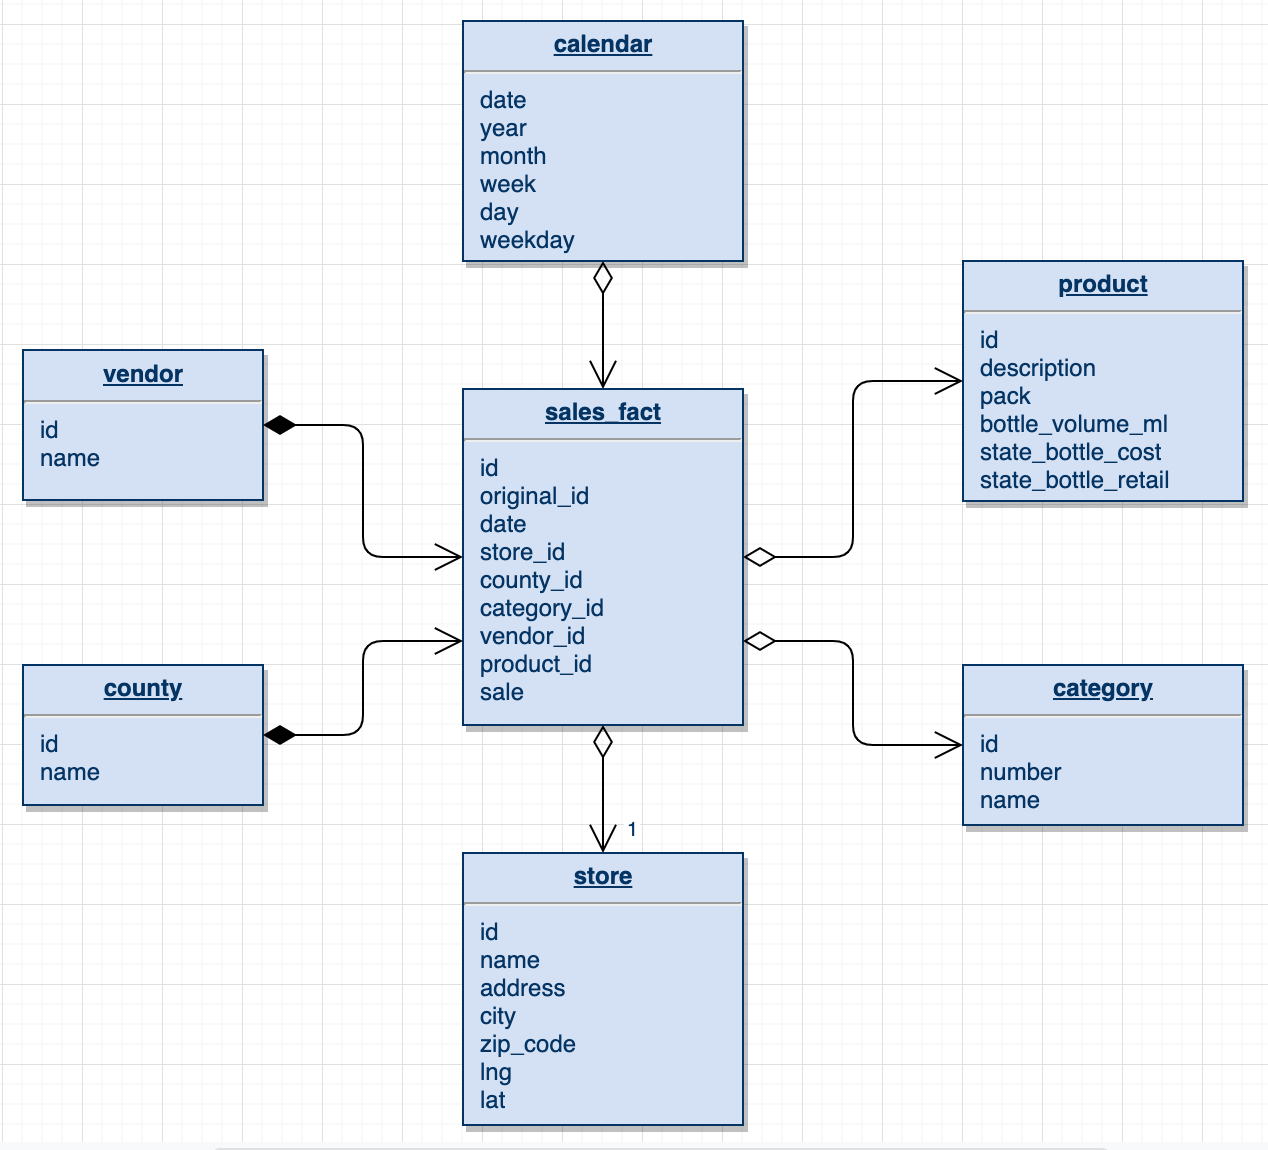

### Create a temporary SQL like table of the data to easier load into new table

In [0]:
# Output path to S3
output_data = 's3a://capstone-dend/DL/'
# Create a Temp View to handle the data as an SQL table
ddf12.createOrReplaceTempView("original_data")

### Calendar DIM Table

#### Creating the view

In [0]:
calendar_table = spark.sql("""
  SELECT 
    DISTINCT date,
    dayofmonth(date) AS day,
    weekofyear(date) AS week,
    month(date) AS month,
    year(date) AS year,
    dayofweek(date) AS weekday
  FROM original_data
""")
calendar_table.show()

#### Data quality check

In [0]:
# Cheking if there is any duplicate value
from pyspark.sql.functions import collect_list, size

calendar_table.groupBy(calendar_table.columns[0]).agg(collect_list('date').alias("dates")).where(size("dates") > 1).show(20, 50)

No duplicate date

#### Writing to S3 as `.parquet`

In [0]:
# Write time table to parquet files partitioned by year and month
print('Writing calendar_table to S3')
calendar_table.write.mode('overwrite').partitionBy("year").parquet(output_data + 'calendar_table/')
print('done!')

### Vendor DIM Table

#### Creating the view

In [0]:
vendor_table = spark.sql("""
  SELECT 
    DISTINCT vendor_number AS id,
    vendor_name AS name
  FROM original_data
""")

#### Data quality check

In [0]:
vendor_table.groupBy(vendor_table.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

Here I have some duplicate values.
I will drop them and keep the first row as valid

In [0]:
vendor_dropD = vendor_table.dropDuplicates(['id'])
vendor_dropD.groupBy(vendor_dropD.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

#### Writing to S3

In [0]:
# Write vendor table to parquet files
print('Writing vendor_table to S3')
vendor_dropD.write.mode('overwrite').parquet(output_data + 'vendor_table/')
print('done!')

### County DIM Table

#### Creating the view

In [0]:
county_table = spark.sql("""
  SELECT 
    DISTINCT county_number AS id,
    county AS name
  FROM original_data
""")

#### Data quality check

In [0]:
county_table.groupBy(county_table.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

Duplicate here too to handle.

In [0]:
county_dropD = county_table.dropDuplicates(['id'])
county_dropD.groupBy(county_dropD.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

#### Writing to S3

In [0]:
# Write county table to parquet files
print('Writing county_table to S3')
county_dropD.write.mode('overwrite').parquet(output_data + 'county_table/')
print('done!')

### Store Table

#### Creating the view

In [0]:
store_table = spark.sql("""
  SELECT 
    DISTINCT store_number AS id,
    store_name AS name,
    address,
    city,
    zip_code
  FROM original_data
""")

#### Data quality check

In [0]:
store_table.groupBy(store_table.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

Here I can see that I have duplicate rows. By looking deeper I can see that it's just typo or lower/uppercase for some identical values. I will drop the duplicate and keep the first `store_id` rows find.

In [0]:
store_dropD = store_table.dropDuplicates(['id'])
store_dropD.groupBy(store_dropD.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

#### Add lat/lng data from Google Geocoding API

I will add the latitude and longitude info to the data to be able to create map dashboard

I will use the Google Geocoding API will the official Google library `googlemaps`

For each value I will create a list of dictionnary with the values the API return and the `store_id` to use it as a merging key.

##### Creating the query list

In [0]:
query_list = []

for row in store_dropD.rdd.collect():
  address = row.address
  city = row.city
  zip_code = row.zip_code
  state = 'IA'
  country = 'USA'

  query = f'{address}, {city}, {zip_code}, {state}, {country}'
  query_list.append({
      'id': row.id,
      'query': query
  })

# Look at what a row look like
print(query_list[0])

In [0]:
!pip install googlemaps

##### Get your own API Key

In [0]:
# To contact the API you need you own key. You can find how to generate the key (free) here :
# https://developers.google.com/maps/documentation/geocoding/get-api-key

import googlemaps

gmaps = googlemaps.Client(key='XXXxxxXXXxxxXXX')

##### API call parallelized

In [0]:
import multiprocessing as mp

def geocoding(row):
  attempts = 0
  success = False

  while success != True and attempts < 3:
    attempts += 1
    geocode_result = gmaps.geocode(row['query'])
    print(geocode_result)
    if (len(geocode_result) > 0):
      return {
          'id': row['id'],
          'lat': geocode_result[0]['geometry']['location']['lat'],
          'lng': geocode_result[0]['geometry']['location']['lng']
      }
    success = True
  
  if attempts == 3:
    # send an alert as this means that the daily limit has been reached
    print("Daily limit has been reached")

pool = mp.Pool(mp.cpu_count() - 1)
geocode_list = pool.map(geocoding, query_list)
pool.close()
pool.join()

print(geocode_list[0])

##### List to DF

In [0]:
# Convert to DF and merge the data.

temp_df = pd.DataFrame(geocode_list)
geocode_df = spark.createDataFrame(temp_df)

geocode_df.show(20, 50)

##### Merging the DF

In [0]:

g = geocode_df.alias('g')
s = store_dropD.alias('s') 
store_augmented = s.join(g, s.id == g.id)
store_augmented.show(20, 50)

#### Writing to S3

In [0]:
# Write store table table to parquet files
print('Writing store_table to S3')
store_augmented.write.mode('overwrite').parquet(output_data + 'store_table/')
print('done!')

### Category Table

#### Creating the view

In [0]:
from pyspark.sql.functions import monotonically_increasing_id

category_table = spark.sql("""
  SELECT
    DISTINCT category AS number,
    category_name AS name
  FROM original_data
""")

# Add another id system
category_table = category_table.withColumn("id", monotonically_increasing_id())

#### Data quality check

In [0]:
category_table.groupBy(category_table.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

#### Writing to S3

In [0]:
# Write category table to parquet files
print('Writing category_table to S3')
category_table.write.mode('overwrite').parquet(output_data + 'category_table/')
print('done!')

### Product Table

#### Creating the view

In [0]:
product_table = spark.sql("""
  SELECT 
    DISTINCT item_number AS id,
    item_description AS description,
    pack,
    bottle_volume_ml,
    state_bottle_cost,
    state_bottle_retail
  FROM original_data
""")
product_table.show()

#### Data quality check

In [0]:
product_table.groupBy(product_table.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

Oops ! Duplicated data here too.

In [0]:
product_dropD = product_table.dropDuplicates(['id'])
product_dropD.groupBy(product_dropD.columns[0]).agg(collect_list('id').alias("ids")).where(size("ids") > 1).show(20, 50)

#### Writing to S3

In [0]:
# Write product table to parquet files
print('Writing product_table to S3')
product_dropD.write.mode('overwrite').parquet(output_data + 'product_table/')
print('done!')

### Sales Fact Table

#### Getting the Data

In [0]:
# Create sale table - let's do it with function instead
sale_table = ddf12.alias('o').join(category_table.alias('c'), (col('c.number') == col('o.category')) & (col('c.name') == col('o.category_name')), how='left')\
            .select(col('o.id'), col('o.date'), col('o.store_number').alias('store_id'), col('o.county_number').alias('county_id'), col('o.vendor_number').alias('vendor_id'), col('o.item_number').alias('product_id'), col('c.id').alias('category_id'), col('o.sale'))

#### Add secondary `id` system and `old_id` column

In [0]:
# Renaming id -> old_id
sale_table2 = sale_table.withColumnRenamed('id', 'original_id')

# Add another id system
sale_table_final = sale_table2.withColumn("id", monotonically_increasing_id())

sale_table_final.show()

#### Data quality check

#### Writing to S3

In [0]:
# Write sale table to parquet files
print('Writing sale_table to S3')
sale_table_final.write.mode('overwrite').parquet(output_data + 'sale_fact_table/')
print('done!')